In [181]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [182]:
tickers = ['AAPL','MSFT','AAL','WMT']
end_date = datetime(year=2021, month=12, day = 31)
#end_date = datetime.today()
start_date = end_date - timedelta(days = 2*365)


In [183]:
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [184]:
print(adj_close_df)

                  AAPL        MSFT        AAL        WMT
Date                                                    
2020-01-02   73.059425  154.493805  28.982893  32.787571
2020-01-03   72.349136  152.570099  27.548195  32.498116
2020-01-06   72.925629  152.964478  27.219410  32.431957
2020-01-07   72.582680  151.569809  27.119778  32.131477
2020-01-08   73.750259  153.984039  27.737495  32.021217
...                ...         ...        ...        ...
2021-12-23  174.066513  328.062073  18.260000  42.386017
2021-12-27  178.065659  335.668396  18.170000  42.771927
2021-12-28  177.038712  334.492157  18.540001  43.385742
2021-12-29  177.127594  335.178314  18.049999  43.364464
2021-12-30  175.962372  332.600372  18.070000  43.504242

[504 rows x 4 columns]


In [185]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [186]:
log_returns = log_returns.dropna()

In [187]:
log_returns

,AAPL,MSFT,AAL,WMT
Date,,,,
2020-01-03,-0.009770,-0.012530,-0.050769,-0.008867
2020-01-06,0.007937,0.002582,-0.012007,-0.002038
2020-01-07,-0.004714,-0.009159,-0.003667,-0.009308
2020-01-08,0.015958,0.015803,0.022522,-0.003437
2020-01-09,0.021018,0.012416,0.003943,0.010278
...,...,...,...,...
2021-12-23,0.003637,0.004462,0.000000,-0.002220
2021-12-27,0.022715,0.022921,-0.004941,0.009063
2021-12-28,-0.005784,-0.003510,0.020159,0.014249


In [188]:
cov_matrix = log_returns.cov() * 252

In [189]:
cov_matrix

,AAPL,MSFT,AAL,WMT
AAPL,0.140707,0.104851,0.064498,0.044889
MSFT,0.104851,0.119046,0.049666,0.044609
AAL,0.064498,0.049666,0.622670,-0.004478
WMT,0.044889,0.044609,-0.004478,0.062863


In [190]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [191]:
risk_free_rate = .02

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [192]:
optimal_weights = optimized_results.x

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
AAPL: 0.5000
MSFT: 0.5000
AAL: 0.0000
WMT: 0.0000
Expected Annual Return: 0.4123
Expected Volatility: 0.3426
Sharpe Ratio: 1.1450


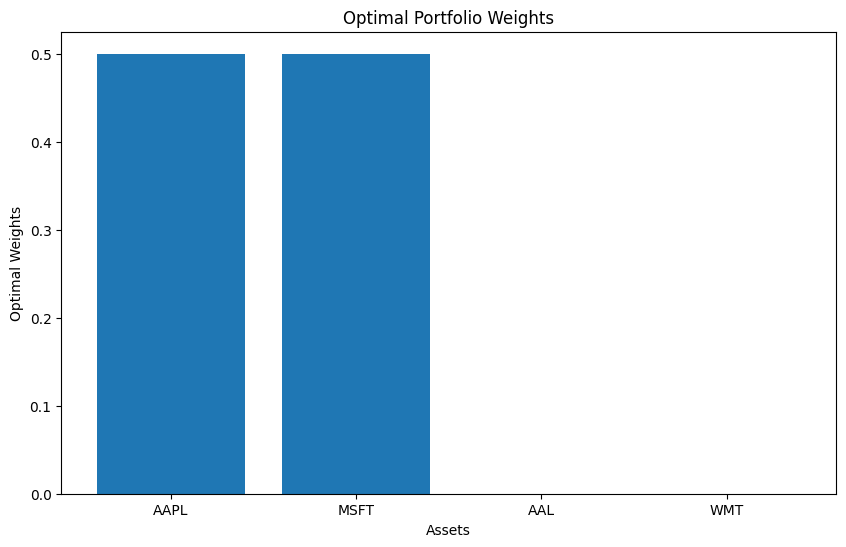

In [193]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()